# Symbol prediction

Predict the symbol ('o' '+', 'x') displayed by an image.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.data
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

## Helper methods

In [2]:
plt.rcParams['image.cmap'] = 'gray'

def remove_ticks(x=True,y=True):
    if x: plt.gca().axes.get_xaxis().set_visible(False)
    if y: plt.gca().axes.get_yaxis().set_visible(False)

def show_pandas_as_images(df, figSize=(15,15),imgPerRow=10,**kwargs):
    """
    Displays the images contained as rows in the passed data frame.
    """
    num_of_images = df.shape[0]
    imgList = df.values.reshape(num_of_images, 10, 10)
    show_images_inRows(imgList, figSize, imgPerRow, **kwargs)

def show_images_inRows(imgList,figSize=(15,15),imgPerRow=10,**kwargs):
    """
    Erstelle aus einer Liste von Pixel-Arrays eine Visualisierung 
    der dazugehörigen Bilder, für den praktischen visuellen Vergleich.
    Gibt jeweils imgPerRow Images in einer Reihe aus
    """
    nImages=len(imgList)
    plt.figure(figsize=figSize)
    for i, currentImage in enumerate(imgList):
        plt.subplot(int(nImages/imgPerRow)+1,imgPerRow,i+1)
        plt.imshow(currentImage, **kwargs);
        remove_ticks()
        
def perform_cross_validation(clf, X, y):
    """
    Performs a cross-validation with the passed classifier and prints the result.
    """
    cv = StratifiedKFold(n_splits=5, random_state=seed)
    cv_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv)
    clf.fit(X, y)
    print("Cross-validation scores:", cv_scores)
    print("Mean:", cv_scores.mean())
    if hasattr(clf, 'feature_importances_'):        
        print("Feature importances:", clf.feature_importances_)
    return

## Read the features from the CSV

In [3]:
# Read data file
all_data = pd.read_csv('data/cleaned_data.csv', header=None)
all_data.shape

(396, 102)

In [4]:
all_data.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,x,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,MK-ABX.csv
1,p,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MK-ABX.csv
2,p,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MK-ABX.csv
3,o,0,0,0,0,1,1,1,1,0,...,0,0,1,1,1,1,0,0,0,MK-ABX.csv
4,x,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,MK-ABX.csv


In [5]:
y = all_data.iloc[:,0]
y.shape

(396,)

In [6]:
y.head()

0    x
1    p
2    p
3    o
4    x
Name: 0, dtype: object

In [7]:
# one hot encoding of y
y_p = np.where(y == 'p', 1, 0)
y_o = np.where(y == 'o', 1, 0)
y_x = np.where(y == 'x', 1, 0)

In [8]:
source = all_data.iloc[:,-1]
source.shape

(396,)

In [9]:
source.head()

0    MK-ABX.csv
1    MK-ABX.csv
2    MK-ABX.csv
3    MK-ABX.csv
4    MK-ABX.csv
Name: 101, dtype: object

In [10]:
X = all_data.iloc[:,1:-1]
X.shape

(396, 100)

In [11]:
X.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,1,1,0,0,...,0,0,0,1,1,1,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


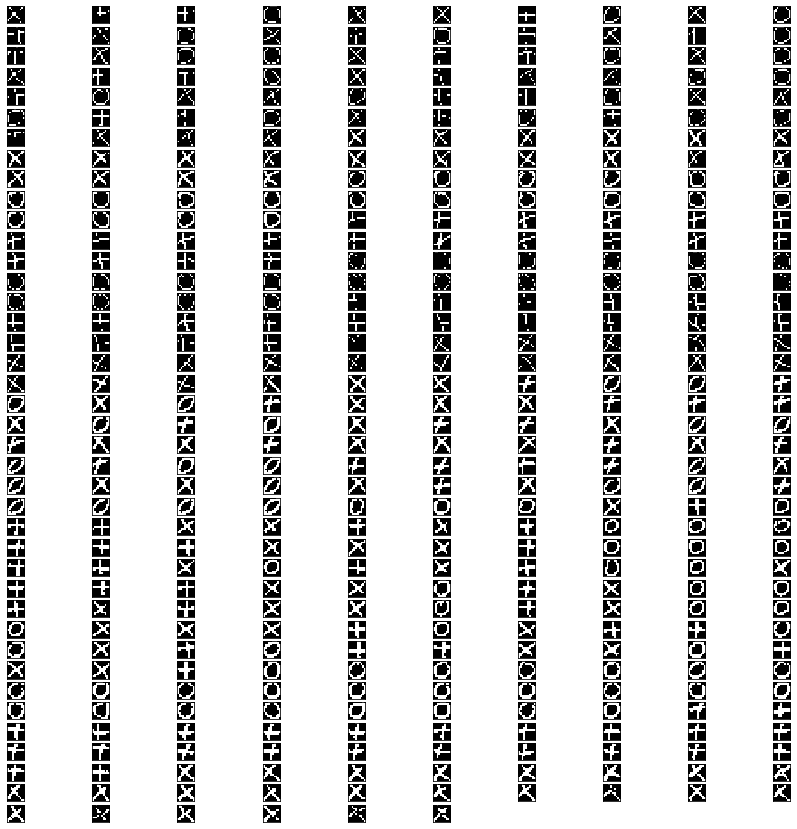

In [12]:
show_pandas_as_images(X, figSize=(15, 15))

## Cross-validation scores for models based on pixels

In [13]:
seed = 42

In [14]:
# Random forest
clf = RandomForestClassifier(n_estimators=100, random_state=seed)
perform_cross_validation(clf, X, y)

Cross-validation scores: [0.97530864 0.925      0.97468354 0.8974359  1.        ]
Mean: 0.9544856167430007
Feature importances: [0.00018495 0.00185837 0.00042321 0.0022441  0.00808044 0.00300894
 0.0028372  0.00132282 0.00254615 0.00715228 0.0005417  0.00899385
 0.00297304 0.00423297 0.00569059 0.00584961 0.00493298 0.01402946
 0.00897371 0.00109221 0.00352893 0.00518949 0.00612485 0.00169057
 0.00193291 0.00161558 0.00166701 0.01016498 0.00661571 0.00208057
 0.00446589 0.00429616 0.00212967 0.00210228 0.00922004 0.00345361
 0.00446346 0.00159795 0.00588442 0.01471867 0.02427177 0.0145191
 0.00318771 0.01888835 0.06282282 0.02505392 0.01080264 0.00841846
 0.00996843 0.02554571 0.04827279 0.01967455 0.01008917 0.02983159
 0.03270901 0.01707809 0.00591216 0.00417072 0.01112645 0.01405912
 0.01992583 0.00365851 0.00999147 0.00915788 0.00862048 0.00407399
 0.00935271 0.00387239 0.00530832 0.01738353 0.00732824 0.04378999
 0.00381867 0.0087151  0.00415263 0.00188052 0.00819505 0.0265515
 0.

In [15]:
# XGBoost
clf = xgb.XGBClassifier(random_state=seed)    
perform_cross_validation(clf, X, y)

Cross-validation scores: [1.         0.9125     0.92405063 0.83333333 1.        ]
Mean: 0.9339767932489451
Feature importances: [0.         0.0008726  0.         0.0104712  0.0104712  0.
 0.01657941 0.0008726  0.0008726  0.04013962 0.         0.0008726
 0.         0.         0.03577662 0.         0.02181501 0.0104712
 0.02966841 0.0026178  0.02268761 0.         0.         0.0052356
 0.0034904  0.         0.         0.0034904  0.0008726  0.004363
 0.         0.0026178  0.0026178  0.0026178  0.01745201 0.0034904
 0.0008726  0.0017452  0.0026178  0.01396161 0.01221641 0.02181501
 0.0078534  0.02792321 0.03141361 0.02268761 0.0069808  0.0113438
 0.0095986  0.02006981 0.02181501 0.0113438  0.0069808  0.01832461
 0.02617801 0.0104712  0.0069808  0.         0.03577662 0.03141361
 0.02006981 0.         0.0104712  0.02094241 0.         0.004363
 0.         0.0026178  0.0017452  0.01221641 0.008726   0.02966841
 0.0113438  0.         0.01832461 0.0078534  0.0034904  0.02530541
 0.01745201 0.0157

In [16]:
# SVM
# -> Seems not to work with categorize
clf = SVC(kernel="rbf", gamma=5, C=1000)    
perform_cross_validation(clf, X, y)

Cross-validation scores: [0.33333333 0.3375     0.32911392 0.33333333 0.33333333]
Mean: 0.33332278481012656


In [17]:
# KNN
clf = KNeighborsClassifier(n_neighbors=10)    
perform_cross_validation(clf, X, y)

Cross-validation scores: [0.96296296 0.925      0.97468354 0.97435897 1.        ]
Mean: 0.9674010963251469


## Cross-validation based on PCA

In [18]:
# PCA on the images
trf = PCA(n_components=3,whiten=True)
X_pca = trf.fit_transform(X)
X_pca.shape

(396, 3)

In [19]:
# reshape to match image size
comp = trf.components_
comp_img=comp.reshape(-1,10,10)
comp_img.shape

(3, 10, 10)

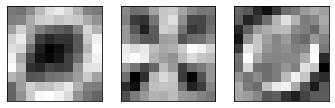

In [20]:
show_images_inRows(comp_img, figSize=(20,20), interpolation='none')

In [21]:
# Random forest
clf = RandomForestClassifier(n_estimators=100, random_state=seed)
perform_cross_validation(clf, X_pca, y)

Cross-validation scores: [0.9382716  0.95       0.94936709 1.         0.98717949]
Mean: 0.9649636361450706
Feature importances: [0.43736018 0.41741351 0.1452263 ]


In [22]:
# XGBoost
clf = xgb.XGBClassifier(random_state=seed)    
perform_cross_validation(clf, X_pca, y)

Cross-validation scores: [0.92592593 0.95       0.94936709 0.98717949 0.98717949]
Mean: 0.959930397778499
Feature importances: [0.34072024 0.4192059  0.24007387]


In [23]:
# KNN
clf = KNeighborsClassifier(n_neighbors=10)    
perform_cross_validation(clf, X_pca, y)

Cross-validation scores: [0.96296296 0.9375     0.94936709 1.         0.98717949]
Mean: 0.9674019077500089


- The PCA improves the accuracy and reduces the training time.

## Add additional features (number of white pixels)

In [24]:
X_extended = X.copy()

# Add number of white pixels
X_extended['NumOfPixelsTotal'] = X.sum(axis=1)

# Add number of white pixels per row
for i in range(10):
    X_extended['NumOfPixelsRow' + str(i)] = X.iloc[:,i*10:i*10+10].sum(axis=1)
    
# Add the relative number of white pixels per row
for i in range(10):
    X_extended['RelNumOfPixelsRow' + str(i)] = X_extended.iloc[:,-10] / X_extended['NumOfPixelsTotal']

X_extended.head()

,1,2,3,4,5,6,7,8,9,10,...,RelNumOfPixelsRow0,RelNumOfPixelsRow1,RelNumOfPixelsRow2,RelNumOfPixelsRow3,RelNumOfPixelsRow4,RelNumOfPixelsRow5,RelNumOfPixelsRow6,RelNumOfPixelsRow7,RelNumOfPixelsRow8,RelNumOfPixelsRow9
0,0,0,0,0,0,0,0,0,0,1,...,0.066667,0.133333,0.133333,0.000000,0.133333,0.133333,0.133333,0.133333,0.066667,0.066667
1,0,0,0,0,1,0,0,0,0,0,...,0.090909,0.090909,0.090909,0.181818,0.454545,0.090909,0.000000,0.000000,0.000000,0.000000
2,0,0,0,0,1,0,0,0,0,0,...,0.066667,0.066667,0.066667,0.133333,0.400000,0.066667,0.066667,0.066667,0.066667,0.000000
3,0,0,0,0,1,1,1,1,0,0,...,0.190476,0.047619,0.095238,0.095238,0.095238,0.095238,0.095238,0.047619,0.047619,0.190476
4,0,0,1,0,0,0,0,0,0,0,...,0.066667,0.066667,0.066667,0.133333,0.133333,0.066667,0.066667,0.133333,0.133333,0.133333


In [25]:
# Random forest
clf = RandomForestClassifier(n_estimators=100, random_state=seed)
perform_cross_validation(clf, X_extended, y)

Cross-validation scores: [0.97530864 0.9625     0.96202532 0.84615385 1.        ]
Mean: 0.9491975609169703
Feature importances: [6.14150740e-04 5.83797691e-04 6.13411491e-04 6.63299927e-04
 4.31737047e-03 5.14425838e-03 9.22094945e-04 2.88193793e-04
 9.15577351e-04 4.33179485e-03 3.84347780e-04 1.37002811e-03
 9.57660996e-04 1.45523889e-03 3.76940105e-03 1.36368544e-03
 8.56261950e-04 6.15014735e-03 2.44393764e-03 1.94598643e-04
 1.32148286e-03 2.70299942e-03 1.08801138e-03 3.73968694e-04
 3.79342647e-04 3.19867220e-04 1.02637697e-03 8.14863378e-04
 1.22780552e-03 2.00099939e-04 5.45523444e-04 1.55359208e-03
 1.16108892e-03 1.39310505e-03 6.92219142e-03 4.25983653e-03
 2.66287677e-03 2.28582497e-04 9.57040031e-04 5.08296389e-03
 1.08167911e-02 1.38114011e-02 1.12468096e-03 2.30845215e-03
 4.08074480e-02 1.09488633e-02 5.17842806e-03 1.90744433e-03
 8.68712337e-03 2.72307671e-02 3.02429644e-02 4.01672094e-03
 1.62823336e-03 1.76453019e-02 2.12402182e-02 9.49192777e-03
 1.75789826e-03 1.

In [26]:
# XGBoost
clf = xgb.XGBClassifier(random_state=seed)    
perform_cross_validation(clf, X_extended, y)

Cross-validation scores: [0.96296296 0.925      0.96202532 0.78205128 0.98717949]
Mean: 0.9238438097298858
Feature importances: [0.         0.         0.         0.00253378 0.00506757 0.
 0.         0.         0.         0.0160473  0.         0.
 0.         0.00168919 0.02195946 0.         0.00760135 0.00760135
 0.00337838 0.         0.00084459 0.00084459 0.         0.00253378
 0.00084459 0.         0.00337838 0.         0.00168919 0.
 0.         0.01097973 0.         0.         0.01773649 0.
 0.00168919 0.00337838 0.0160473  0.00084459 0.0152027  0.00591216
 0.         0.02111487 0.04560811 0.         0.00675676 0.
 0.00253378 0.02787162 0.01858108 0.00591216 0.         0.00929054
 0.02533784 0.         0.         0.         0.01858108 0.01351351
 0.00084459 0.00168919 0.         0.00168919 0.00675676 0.
 0.00084459 0.00168919 0.00084459 0.         0.00253378 0.00506757
 0.00084459 0.00168919 0.01435811 0.00168919 0.         0.00506757
 0.00084459 0.00337838 0.00168919 0.01351351 0.  

In [27]:
# KNN
clf = KNeighborsClassifier(n_neighbors=10)    
perform_cross_validation(clf, X_extended, y)

Cross-validation scores: [0.91358025 0.825      0.92405063 0.79487179 0.98717949]
Mean: 0.888936432375251


- The additional features do not add any benefits. In contrast, the accuracy gets worse (especially with KNN).

## Predict source based on pixels

In [39]:
# Random forest based on pixels
clf = RandomForestClassifier(n_estimators=100, random_state=seed)
perform_cross_validation(clf, X, source)

Cross-validation scores: [0.5875     0.7375     0.59493671 0.79746835 0.61538462]
Mean: 0.666557935735151
Feature importances: [0.00378839 0.00456444 0.01351142 0.01068785 0.00769782 0.0088427
 0.00644724 0.00534672 0.01121451 0.01204601 0.00315103 0.01221593
 0.00968463 0.00955213 0.00959057 0.01217601 0.00899667 0.01028686
 0.01212616 0.00892006 0.00678303 0.01012219 0.0110877  0.01208484
 0.01246287 0.01086581 0.00703284 0.00568086 0.01008986 0.00824637
 0.00708639 0.00766199 0.00873219 0.01058918 0.01393618 0.01685656
 0.01100641 0.01185058 0.01315087 0.01161628 0.01107331 0.01158166
 0.00647262 0.01032562 0.0147831  0.01675625 0.01654088 0.01004593
 0.01376198 0.00741039 0.00629869 0.01895526 0.01016439 0.01283018
 0.01106589 0.01047057 0.01263921 0.0070274  0.01814839 0.00968244
 0.00572026 0.01084521 0.00756338 0.01370705 0.00776434 0.01100203
 0.00483646 0.01026701 0.00766412 0.0068737  0.01416875 0.02118166
 0.01081806 0.00762551 0.00476523 0.01512096 0.00838296 0.01029259
 0.

In [40]:
# Random forest based on PCA
clf = RandomForestClassifier(n_estimators=100, random_state=seed)
perform_cross_validation(clf, X_pca, source)

Cross-validation scores: [0.475      0.475      0.43037975 0.50632911 0.35897436]
Mean: 0.4491366439467705
Feature importances: [0.30972904 0.28522969 0.40504127]


In [41]:
# Random forest based on extended features
clf = RandomForestClassifier(n_estimators=100, random_state=seed)
perform_cross_validation(clf, X_extended, source)

Cross-validation scores: [0.6375     0.7125     0.73417722 0.82278481 0.61538462]
Mean: 0.7044693281402142
Feature importances: [0.0029075  0.00106304 0.00499011 0.0054687  0.00248162 0.00279877
 0.0026138  0.0023105  0.00794023 0.00708703 0.00131109 0.00928113
 0.00494846 0.00580836 0.00372744 0.00624652 0.0041539  0.00568167
 0.00612937 0.00380919 0.00489753 0.00687346 0.00345974 0.00315407
 0.0122239  0.00553759 0.00238837 0.00178796 0.00767008 0.00297382
 0.0046339  0.00255982 0.00233402 0.00328463 0.00684014 0.00721685
 0.00349334 0.00310168 0.00654839 0.00635734 0.0043332  0.00675066
 0.00372946 0.00457596 0.00591164 0.00836988 0.00564274 0.00439331
 0.00507442 0.00373302 0.00310722 0.00739956 0.00457479 0.00410565
 0.00407978 0.00757222 0.00734691 0.00316072 0.00909123 0.00548578
 0.00253908 0.00290359 0.00354852 0.00547698 0.00242206 0.00809963
 0.00191343 0.00579965 0.00269842 0.00379338 0.0091595  0.00708912
 0.00297926 0.00550782 0.00225807 0.01042107 0.00256689 0.00470179
 

- It seems not be easy to identify the source only based on the pixels.
- The additional features (number of white pixels) improve the accuracy to identify the source.
- With PCA, the source is hardly possible to identify -> Conclusion: PCA helps to adress the differences betweeen the different sources.